## 데이터 준비

In [1]:
from tensorflow.keras.datasets import fashion_mnist

# 전체 6만개 데이터 중, 5만개는 학습 데이터용, 1만개는 테스트 데이터용으로 분리
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# image size는 28 x 28의 gray scale 2차원 데이터
print("train data shape: ", train_images.shape, train_labels.shape)  # 6만개, 28 x 28
print("test data shape: ", test_images.shape, test_labels.shape)   # 1만개, 28 x 28

4423680/4422102 [==============================] - 0s 0us/step
train data shape:  (60000, 28, 28) (60000,)
test data shape:  (10000, 28, 28) (10000,)


In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# 0 ~ 1 사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels):
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    return images, labels

# 0 ~ 1 사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    oh_labels = to_categorical(labels)

    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):

    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)

    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
            get_train_valid_test_set(train_images, train_labels, test_images, test_labels)
print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(51000, 28, 28) (51000, 10) (9000, 28, 28) (9000, 10) (10000, 28, 28) (10000, 10)


## 모델 생성

### 주의사항
- Flatten에서 Dense로 넘어가면서 Param이 급격하게 커진다.
- cnn에서 classification으로 넘어갈 때, Flatten 이후 바로 사용하면 overfitting이 일어나기 쉽다.  


In [4]:
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
# Convolutional Nural Network
input_tensor = Input(shape=(28, 28, 1))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor) 
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x) # padding의 default는 'valid'
x = MaxPooling2D(2)(x)
# Fully Connected
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1081700   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010  

In [5]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

## 모델 학습

In [6]:
history = model.fit(x=tr_images, y=tr_oh_labels, validation_data=(val_images, val_oh_labels), epochs=30, batch_size=128)

Epoch 1/30
399/399 [==============================] - 10s 7ms/step - loss: 0.6514 - accuracy: 0.7735 - val_loss: 0.3414 - val_accuracy: 0.8797
Epoch 2/30
399/399 [==============================] - 2s 6ms/step - loss: 0.2894 - accuracy: 0.8958 - val_loss: 0.2646 - val_accuracy: 0.9068
Epoch 3/30
399/399 [==============================] - 2s 6ms/step - loss: 0.2165 - accuracy: 0.9211 - val_loss: 0.2410 - val_accuracy: 0.9126
Epoch 4/30
399/399 [==============================] - 2s 6ms/step - loss: 0.1790 - accuracy: 0.9358 - val_loss: 0.2541 - val_accuracy: 0.9093
Epoch 5/30
399/399 [==============================] - 2s 6ms/step - loss: 0.1498 - accuracy: 0.9453 - val_loss: 0.2351 - val_accuracy: 0.9183
Epoch 6/30
399/399 [==============================] - 2s 6ms/step - loss: 0.1243 - accuracy: 0.9545 - val_loss: 0.2365 - val_accuracy: 0.9203
Epoch 7/30
399/399 [==============================] - 2s 6ms/step - loss: 0.0965 - accuracy: 0.9667 - val_loss: 0.2431 - val_accuracy: 0.9220
Epoch

## 성능 시각화
- train은 100%에 가까운 정확도를 보이지만, val은 정확도가 떨어지고 있다

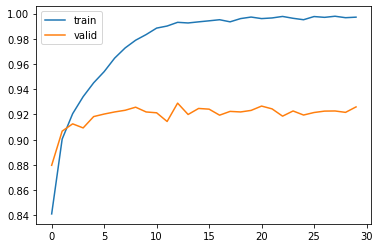

In [7]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['accuracy'],  label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    plt.show()

show_history(history)

## Dropout을 적용하여 Fully Connected Layer의 오버피티 조정
- CNN은 일반적으로 Dense Layer보다는 파라미터수(weight 수) 작음
- 하지만 많은 Filter 들을 적용하고 이를 Fully Connected Layer로 연결 시 파라미터 수가 늘어남
- Flatten() 이후 Dropout을 적용하여 특정 비율로 FC Layer 연결을 누락 적용.

In [10]:
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
# Convolutional Nural Network
input_tensor = Input(shape=(28, 28, 1))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor) 
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x) # padding의 default는 'valid'
x = MaxPooling2D(2)(x)
# Fully Connected
x = Flatten()(x)
x = Dropout(rate=0.5)(x) # param에서 계산은 안되지만, 연결을 끊어준다.
x = Dense(100, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10816)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1081

In [12]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(x=tr_images, y=tr_oh_labels, validation_data=(val_images, val_oh_labels), epochs=30, batch_size=128)

Epoch 1/30
399/399 [==============================] - 3s 7ms/step - loss: 0.6508 - accuracy: 0.7705 - val_loss: 0.3177 - val_accuracy: 0.8856
Epoch 2/30
399/399 [==============================] - 2s 6ms/step - loss: 0.3108 - accuracy: 0.8876 - val_loss: 0.2722 - val_accuracy: 0.9043
Epoch 3/30
399/399 [==============================] - 3s 6ms/step - loss: 0.2566 - accuracy: 0.9061 - val_loss: 0.2411 - val_accuracy: 0.9136
Epoch 4/30
399/399 [==============================] - 3s 7ms/step - loss: 0.2214 - accuracy: 0.9192 - val_loss: 0.2399 - val_accuracy: 0.9129
Epoch 5/30
399/399 [==============================] - 2s 6ms/step - loss: 0.1889 - accuracy: 0.9305 - val_loss: 0.2305 - val_accuracy: 0.9150
Epoch 6/30
399/399 [==============================] - 2s 6ms/step - loss: 0.1689 - accuracy: 0.9369 - val_loss: 0.2176 - val_accuracy: 0.9196
Epoch 7/30
399/399 [==============================] - 2s 6ms/step - loss: 0.1505 - accuracy: 0.9434 - val_loss: 0.2094 - val_accuracy: 0.9251
Epoch 

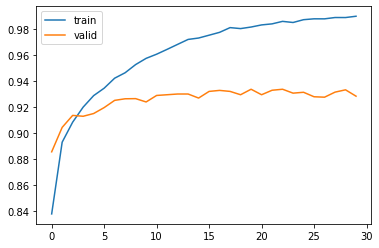

In [14]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['accuracy'],  label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    plt.show()

show_history(history)

In [15]:
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model

def create_model():
    # Convolutional Nural Network
    input_tensor = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor) 
    x = Conv2D(filters=64, kernel_size=3, activation='relu')(x) # padding의 default는 'valid'
    x = MaxPooling2D(2)(x)
    # Fully Connected
    x = Flatten()(x)
    x = Dropout(rate=0.5)(x) # 50%
    x = Dense(200, activation='relu')(x)
    x = Dropout(rate=0.2)(x) # 20%
    output = Dense(10, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
    
    return model

model = create_model()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10816)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               2163

In [16]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=tr_images, y=tr_oh_labels, validation_data=(val_images, val_oh_labels), epochs=30, batch_size=128)

Epoch 1/30
399/399 [==============================] - 3s 7ms/step - loss: 0.6316 - accuracy: 0.7747 - val_loss: 0.3132 - val_accuracy: 0.8880
Epoch 2/30
399/399 [==============================] - 3s 7ms/step - loss: 0.3031 - accuracy: 0.8898 - val_loss: 0.2596 - val_accuracy: 0.9054
Epoch 3/30
399/399 [==============================] - 3s 7ms/step - loss: 0.2539 - accuracy: 0.9073 - val_loss: 0.2336 - val_accuracy: 0.9151
Epoch 4/30
399/399 [==============================] - 3s 7ms/step - loss: 0.2183 - accuracy: 0.9193 - val_loss: 0.2214 - val_accuracy: 0.9172
Epoch 5/30
399/399 [==============================] - 3s 7ms/step - loss: 0.1923 - accuracy: 0.9276 - val_loss: 0.2108 - val_accuracy: 0.9216
Epoch 6/30
399/399 [==============================] - 3s 7ms/step - loss: 0.1693 - accuracy: 0.9375 - val_loss: 0.2035 - val_accuracy: 0.9257
Epoch 7/30
399/399 [==============================] - 3s 7ms/step - loss: 0.1489 - accuracy: 0.9443 - val_loss: 0.1954 - val_accuracy: 0.9304
Epoch 

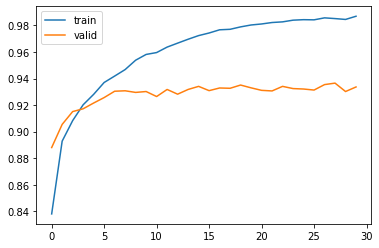

40/40 [==============================] - 0s 4ms/step - loss: 0.3128 - accuracy: 0.9299


[0.3127729594707489, 0.9298999905586243]

In [17]:
show_history(history)
model.evaluate(test_images, test_oh_labels, batch_size=256, verbose=1)

In [19]:
(train_images, train_labels), (test_images, test_lables) = fashion_mnist.load_data()

print('befor reshape:',  train_images.shape, test_images.shape)
train_images = np.reshape(train_images, (60000, 28, 28, 1))
test_images = np.reshape(test_images, (10000, 28, 28, 1))
print('after reshape:', train_images.shape, test_images.shape)

befor reshape: (60000, 28, 28) (10000, 28, 28)
after reshape: (60000, 28, 28, 1) (10000, 28, 28, 1)
